In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Optional: Set global print options for pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('customer_segmentation.csv')

# Confirm successful load
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")  # (rows, columns)

# Display first few rows
display(df.head())

# Check for missing values
print("\n🧹 Missing Values:")
print(df.isnull().sum())


✅ Dataset loaded successfully!
📊 Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0



🧹 Missing Values:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [5]:
print(df.columns.tolist())


['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


**Handle Missing Income Values (24 missing)**

In [6]:
# Fill missing Income with median (safer than mean due to outliers)
df['Income'] = df['Income'].fillna(df['Income'].median())


**Drop Target Product Columns**

In [7]:
target_products = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_features = df.drop(columns=target_products)


**Create Target Variable TargetProduct (based on highest spending)**

In [8]:
product_map = {
    'MntWines': 0,
    'MntFruits': 1,
    'MntMeatProducts': 2,
    'MntFishProducts': 3,
    'MntSweetProducts': 4,
    'MntGoldProds': 5
}

df['TargetProduct'] = df[target_products].idxmax(axis=1).map(product_map)


Now TargetProduct has values from 0 to 5 representing the most spent product category:

0 → Wine

1 → Fruits

2 → Meat

3 → Fish

4 → Sweets

5 → Gold

**Feature Engineering – Age & Children**

In [9]:
# Age from Year_Birth
df['Age'] = 2025 - df['Year_Birth']

# Total children at home
df['Children'] = df['Kidhome'] + df['Teenhome']


**Drop Useless Columns**

In [10]:
# Drop columns not useful for modeling
df_model = df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'])


In [11]:
# Drop product amount columns (already used to create TargetProduct)
df_model = df_model.drop(columns=target_products)


**Encode Categorical Variables**

In [12]:
# One-hot encode categorical variables (drop_first avoids multicollinearity)
df_model = pd.get_dummies(df_model, columns=['Education', 'Marital_Status'], drop_first=True)


**Standardize Features (excluding the target)**

In [13]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_model.drop(columns=['TargetProduct'])
y = df_model['TargetProduct']

# Standardize numeric features only
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [14]:
# Step: Create Children column again, just to be safe
df['Children'] = df['Kidhome'] + df['Teenhome']

# Step: Drop Kidhome and Teenhome
df = df.drop(columns=['Kidhome', 'Teenhome'])


In [15]:
# Drop unused columns again
df_model = df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'])

# Redo encoding and standardization
df_model = pd.get_dummies(df_model, columns=['Education', 'Marital_Status'], drop_first=True)

# Drop product amount columns again
df_model = df_model.drop(columns=target_products)

# Redefine X and y
X = df_model.drop(columns=['TargetProduct'])
y = df_model['TargetProduct']

# Standardize
from sklearn.preprocessing import StandardScaler
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


**Training the Model**

In [16]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**Baseline Logistic Regression**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

# Predict
y_pred_log = log_reg.predict(X_test)

# Report
print("📊 Classification Report — Logistic Regression:")
print(classification_report(y_test, y_pred_log))


📊 Classification Report — Logistic Regression:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       308
           1       0.00      0.00      0.00         3
           2       0.50      0.16      0.24        89
           3       0.33      0.08      0.13        12
           4       0.00      0.00      0.00         3
           5       0.50      0.42      0.46        33

    accuracy                           0.73       448
   macro avg       0.35      0.27      0.28       448
weighted avg       0.67      0.73      0.67       448



**Baseline k-Nearest Neighbors (k-NN)**

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Report
print("📊 Classification Report — k-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn))


📊 Classification Report — k-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       308
           1       0.00      0.00      0.00         3
           2       0.45      0.35      0.39        89
           3       0.22      0.17      0.19        12
           4       0.00      0.00      0.00         3
           5       0.42      0.15      0.22        33

    accuracy                           0.71       448
   macro avg       0.31      0.26      0.27       448
weighted avg       0.67      0.71      0.68       448



**Baseline Decision Tree Classifier**

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Train
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

# Report
print("📊 Classification Report — Decision Tree:")
print(classification_report(y_test, y_pred_dt))


📊 Classification Report — Decision Tree:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       1.00      0.67      0.80         3
           2       0.47      0.45      0.46        89
           3       0.31      0.33      0.32        12
           4       0.33      0.33      0.33         3
           5       0.43      0.36      0.39        33

    accuracy                           0.71       448
   macro avg       0.56      0.50      0.52       448
weighted avg       0.71      0.71      0.71       448



**Baseline Random Forest Classifier**

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Report
print("📊 Classification Report — Random Forest:")
print(classification_report(y_test, y_pred_rf))


📊 Classification Report — Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       308
           1       1.00      0.67      0.80         3
           2       0.44      0.26      0.33        89
           3       0.67      0.33      0.44        12
           4       1.00      0.33      0.50         3
           5       0.61      0.42      0.50        33

    accuracy                           0.73       448
   macro avg       0.75      0.49      0.57       448
weighted avg       0.70      0.73      0.71       448



**Baseline XGBoost Classifier**

In [21]:
from xgboost import XGBClassifier

# Train
xgb = XGBClassifier(objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Report
print("📊 Classification Report — XGBoost:")
print(classification_report(y_test, y_pred_xgb))


📊 Classification Report — XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       308
           1       0.67      0.67      0.67         3
           2       0.55      0.46      0.50        89
           3       0.40      0.33      0.36        12
           4       0.33      0.33      0.33         3
           5       0.68      0.45      0.55        33

    accuracy                           0.76       448
   macro avg       0.58      0.53      0.55       448
weighted avg       0.75      0.76      0.75       448



**Baseline Feature Importance**

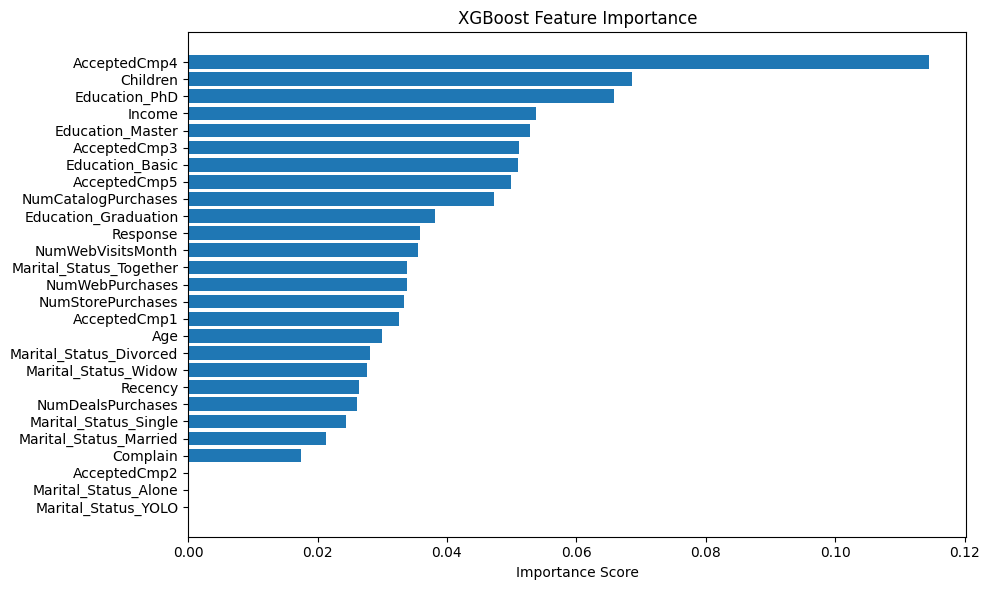

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance scores from XGBoost
importances = xgb.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [23]:
# Top 10 features based on importance
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)['Feature'].tolist()
print("🎯 Top 10 features:", top_10_features)


🎯 Top 10 features: ['AcceptedCmp4', 'Children', 'Education_PhD', 'Income', 'Education_Master', 'AcceptedCmp3', 'Education_Basic', 'AcceptedCmp5', 'NumCatalogPurchases', 'Education_Graduation']


**Re-training the model for better result**

**Keep Only Top 10 Features**

In [24]:
# Final top 10 features list
top_10_features = [
    'AcceptedCmp4', 'Children', 'Education_PhD', 'Income',
    'Education_Master', 'AcceptedCmp3', 'Education_Basic',
    'AcceptedCmp5', 'NumCatalogPurchases', 'Education_Graduation'
]

# Reduce X to top 10 features
X_top10 = X[top_10_features]


**New Train-Test Split**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42, stratify=y)


**Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("📊 Classification Report — Logistic Regression (Top 10 Features):")
print(classification_report(y_test, y_pred_log))


📊 Classification Report — Logistic Regression (Top 10 Features):
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       308
           1       0.00      0.00      0.00         3
           2       0.33      0.04      0.08        89
           3       0.50      0.08      0.14        12
           4       0.00      0.00      0.00         3
           5       0.57      0.39      0.46        33

    accuracy                           0.72       448
   macro avg       0.36      0.25      0.26       448
weighted avg       0.63      0.72      0.64       448



k-Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("📊 Classification Report — k-NN (Top 10 Features):")
print(classification_report(y_test, y_pred_knn))


📊 Classification Report — k-NN (Top 10 Features):
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       308
           1       0.00      0.00      0.00         3
           2       0.47      0.29      0.36        89
           3       0.50      0.17      0.25        12
           4       0.00      0.00      0.00         3
           5       0.48      0.36      0.41        33

    accuracy                           0.72       448
   macro avg       0.37      0.29      0.31       448
weighted avg       0.68      0.72      0.69       448



In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("📊 Classification Report — Decision Tree (Top 10 Features):")
print(classification_report(y_test, y_pred_dt))


📊 Classification Report — Decision Tree (Top 10 Features):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       308
           1       0.50      0.67      0.57         3
           2       0.42      0.36      0.39        89
           3       0.36      0.33      0.35        12
           4       0.50      0.33      0.40         3
           5       0.50      0.48      0.49        33

    accuracy                           0.70       448
   macro avg       0.51      0.50      0.50       448
weighted avg       0.69      0.70      0.69       448



In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📊 Classification Report — Random Forest (Top 10 Features):")
print(classification_report(y_test, y_pred_rf))


📊 Classification Report — Random Forest (Top 10 Features):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       308
           1       0.40      0.67      0.50         3
           2       0.53      0.37      0.44        89
           3       0.33      0.42      0.37        12
           4       0.25      0.33      0.29         3
           5       0.57      0.52      0.54        33

    accuracy                           0.73       448
   macro avg       0.48      0.53      0.50       448
weighted avg       0.72      0.73      0.72       448



In [30]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("📊 Classification Report — XGBoost (Top 10 Features):")
print(classification_report(y_test, y_pred_xgb))


📊 Classification Report — XGBoost (Top 10 Features):
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       308
           1       0.67      0.67      0.67         3
           2       0.47      0.38      0.42        89
           3       0.40      0.33      0.36        12
           4       1.00      0.33      0.50         3
           5       0.63      0.52      0.57        33

    accuracy                           0.74       448
   macro avg       0.66      0.52      0.56       448
weighted avg       0.72      0.74      0.72       448



**Check Target Distribution — Is It Balanced?**

In [31]:
print(y.value_counts(normalize=True))


TargetProduct
0    0.687054
2    0.197768
5    0.075000
3    0.026339
4    0.007143
1    0.006696
Name: proportion, dtype: float64


**Apply SMOTE**

In [32]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
!pip uninstall -y imbalanced-learn scikit-learn
!pip install -U scikit-learn imbalanced-learn


Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1


You can safely remove it manually.


  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top10, y)

print("✅ Resampling completed!")
print("🔢 Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


✅ Resampling completed!
🔢 Class distribution after SMOTE:
TargetProduct
0    1539
2    1539
1    1539
3    1539
5    1539
4    1539
Name: count, dtype: int64


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [37]:
X_full = X  # this should include all scaled, cleaned, encoded features
X_resampled, y_resampled = smote.fit_resample(X_full, y)


**Create New Behavioral Features**

In [38]:
# 1. Total campaign engagement
df['Campaign_Score'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# 2. Total number of purchases
df['TotalPurchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# 3. Online engagement (visits + web purchases)
df['OnlineEngagement'] = df['NumWebPurchases'] + df['NumWebVisitsMonth']


**Rebuild Feature Set**

In [ ]:
# Drop unused columns and rebuild feature set
df_model = df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'] + target_products)

# Re-encode categorical
df_model = pd.get_dummies(df_model, columns=['Education', 'Marital_Status'], drop_first=True)

# Redefine X and y
X_all = df_model.drop(columns=['TargetProduct'])
y_all = df_model['TargetProduct']

# Standardize
from sklearn.preprocessing import StandardScaler
numeric_cols = X_all.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_all[numeric_cols] = scaler.fit_transform(X_all[numeric_cols])


**Apply SMOTE Again**

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled_all, y_resampled_all = smote.fit_resample(X_all, y_all)


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled_all, y_resampled_all, test_size=0.2, random_state=42, stratify=y_resampled_all)


**MODEL RESULTS (SMOTE)**

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("📊 Classification Report — Logistic Regression (All Features + SMOTE):")
print(classification_report(y_test, y_pred_log))


📊 Classification Report — Logistic Regression (All Features + SMOTE):
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       307
           1       0.74      0.76      0.75       308
           2       0.62      0.58      0.60       308
           3       0.49      0.56      0.52       308
           4       0.71      0.72      0.72       308
           5       0.55      0.49      0.52       308

    accuracy                           0.64      1847
   macro avg       0.65      0.64      0.64      1847
weighted avg       0.65      0.64      0.64      1847



In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("📊 Classification Report — k-NN (All Features + SMOTE):")
print(classification_report(y_test, y_pred_knn))


📊 Classification Report — k-NN (All Features + SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       307
           1       0.99      1.00      0.99       308
           2       0.80      0.84      0.82       308
           3       0.92      0.99      0.95       308
           4       0.98      1.00      0.99       308
           5       0.89      0.95      0.92       308

    accuracy                           0.91      1847
   macro avg       0.91      0.91      0.91      1847
weighted avg       0.91      0.91      0.91      1847



In [55]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("📊 Classification Report — Decision Tree (All Features + SMOTE):")
print(classification_report(y_test, y_pred_dt))


📊 Classification Report — Decision Tree (All Features + SMOTE):
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       307
           1       0.98      0.99      0.98       308
           2       0.78      0.77      0.77       308
           3       0.91      0.92      0.91       308
           4       0.99      0.99      0.99       308
           5       0.85      0.90      0.88       308

    accuracy                           0.89      1847
   macro avg       0.89      0.89      0.89      1847
weighted avg       0.89      0.89      0.89      1847



In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📊 Classification Report — Random Forest (All Features + SMOTE):")
print(classification_report(y_test, y_pred_rf))


📊 Classification Report — Random Forest (All Features + SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       307
           1       1.00      1.00      1.00       308
           2       0.90      0.86      0.88       308
           3       0.97      0.99      0.98       308
           4       1.00      1.00      1.00       308
           5       0.95      0.97      0.96       308

    accuracy                           0.95      1847
   macro avg       0.95      0.95      0.95      1847
weighted avg       0.95      0.95      0.95      1847



In [57]:
from xgboost import XGBClassifier
import numpy as np

xgb = XGBClassifier(objective='multi:softprob', num_class=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Use predict_proba + argmax for better class confidence handling
y_proba_xgb = xgb.predict_proba(X_test)
y_pred_xgb = np.argmax(y_proba_xgb, axis=1)

print("📊 Classification Report — XGBoost (All Features + SMOTE):")
print(classification_report(y_test, y_pred_xgb))


📊 Classification Report — XGBoost (All Features + SMOTE):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       307
           1       1.00      1.00      1.00       308
           2       0.92      0.84      0.88       308
           3       0.97      1.00      0.98       308
           4       1.00      1.00      1.00       308
           5       0.96      0.95      0.96       308

    accuracy                           0.95      1847
   macro avg       0.95      0.95      0.95      1847
weighted avg       0.95      0.95      0.95      1847

